$\textbf{Voltage and Bowl Calibration}$

$\text{After the cropping the dataset we can do the voltage and bowl correction to clibrate the data.}$

In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from IPython.display import display

from pyccapt.calibration_tools import variables, tools, data_tools
from pyccapt.calibration_tools import widgets as wd
from pyccapt.mc import mc_tools

# The initial value for flight path length, which is the distance of local electrod to detector 
flightPathLength = 110 # 105.35 # mm 
# The initial value for t_0
t0 = 51.74 #68.48 # ns


In [2]:
variables.init()

# dataset name
# dataset_name = 'AL_data_b'
dataset_name = 'OLO_AL_6_data'
# dataset_name = 'OLO_W_6_data'
# dataset_name = 'OLO_Ni_8_data'
# dataset_name = 'X6Cr17_2V30Min_5_data'

p = path.abspath(path.join("", "../../../../.."))

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/vol_bowl_calibratin/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)
print(data)

dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
dld_startCounter = data['dld/start_counter'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

         dld/high_voltage  dld/pulse_voltage  dld/start_counter       dld/t  \
0             5279.886719        5279.886719            50876.0  635.455422   
1             5279.886719        5279.886719            51066.0  633.631194   
2             5279.886719        5279.886719            51106.0  621.471960   
3             5279.886719        5279.886719            51704.0  477.584262   
4             5279.886719        5279.886719            51996.0  469.238076   
...                   ...                ...                ...         ...   
1851920       5711.026855        5711.026855             1172.0  443.692026   
1851921       5711.026855        5711.026855             1219.0  602.955360   
1851922       5711.026855        5711.026855             1272.0  621.245646   
1851923       5711.026855        5711.026855             1281.0  449.466462   
1851924       5711.026855        5711.026855             1648.0  602.893638   

             dld/x      dld/y  
0       -19.006531 

In [3]:
# t0
dld_t = dld_t - t0

In [4]:
# Remove negative and zero TOF
threshold = 60
dld_highVoltage = dld_highVoltage[dld_t>threshold]
dld_pulseVoltage = dld_pulseVoltage[dld_t>threshold]
dld_startCounter = dld_startCounter[dld_t>threshold]
dld_x = dld_x[dld_t>threshold]
dld_y = dld_y[dld_t>threshold]
dld_t = dld_t[dld_t>threshold]

$\text{Plot the m/c. It is possible to modify the peak selection algorithm by seting different value for prominance and distance variable in massSpecPlot function.}$

<IPython.core.display.Javascript object>


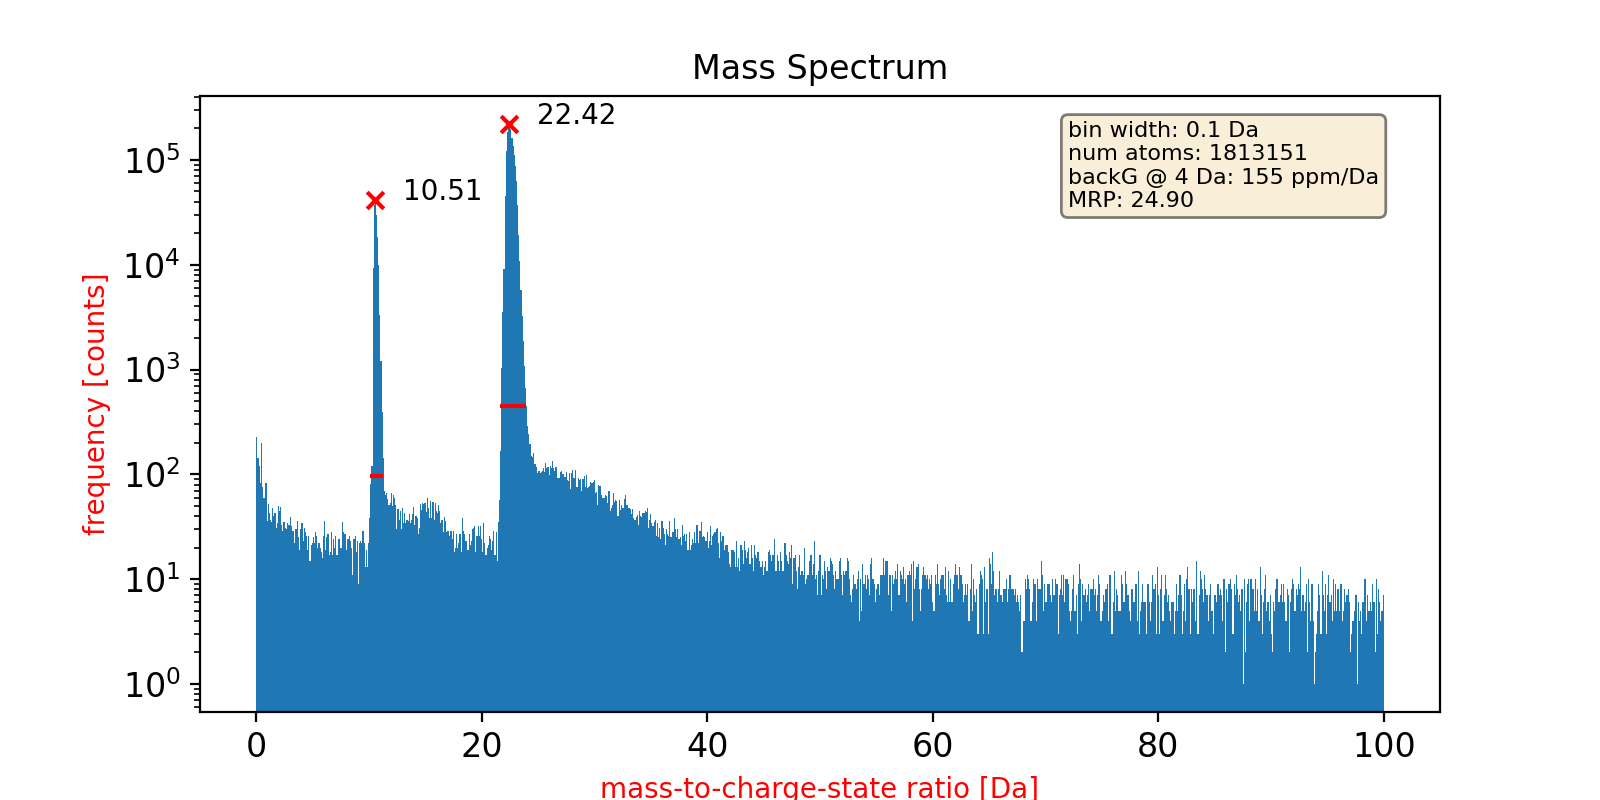

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [24.89528023]
Peaks  0 is: 10.51 peak window sides are: 10.31 - 10.71
Peaks  1 is: 22.42 peak window sides are: 22.02 - 22.92


In [5]:
mc_seb = mc_tools.tof2mc(dld_t, t0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, percent=50, prominence=100, distance=100, plot=True, text_loc='right', fig_name=figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))

$\text{Details of selected peaks is displayed below:}$

In [6]:
print('################ Before starting the colibration ################')
print('Maximum pick value:', max_hist, 'right-left side of the peak:', left_right_peaks)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))
print('#################################################################')

################ Before starting the colibration ################
Maximum pick value: [22.42259637] right-left side of the peak: [22.02229566 22.92297226]
Mass resolving power (MRP --> m/m_2-m_1): [24.89528023]
Peaks  0 is: 10.51 peak window sides are: 10.31 - 10.71
Peaks  1 is: 22.42 peak window sides are: 22.02 - 22.92
#################################################################


$\text{User can tune/specify parameters below as per their requirements}$

In [7]:
mc_temp = mc_seb
mean_t = 0.3  # the threshold by user instead of total mean
mrp_final = 0
iteration = 0
break_i = 0
ionsPerFitSegment = int(len(dld_t) / 70) # choose by dividing the dataset to 70 segments
print('Ions fit per segment is:',  ionsPerFitSegment)

Ions fit per segment is: 26441


$\text{Computation voltage and bowl correction based on the user-provided parameters. The loop breaks if there is no improvment in MRP for 3 itrations}$

<IPython.core.display.Javascript object>


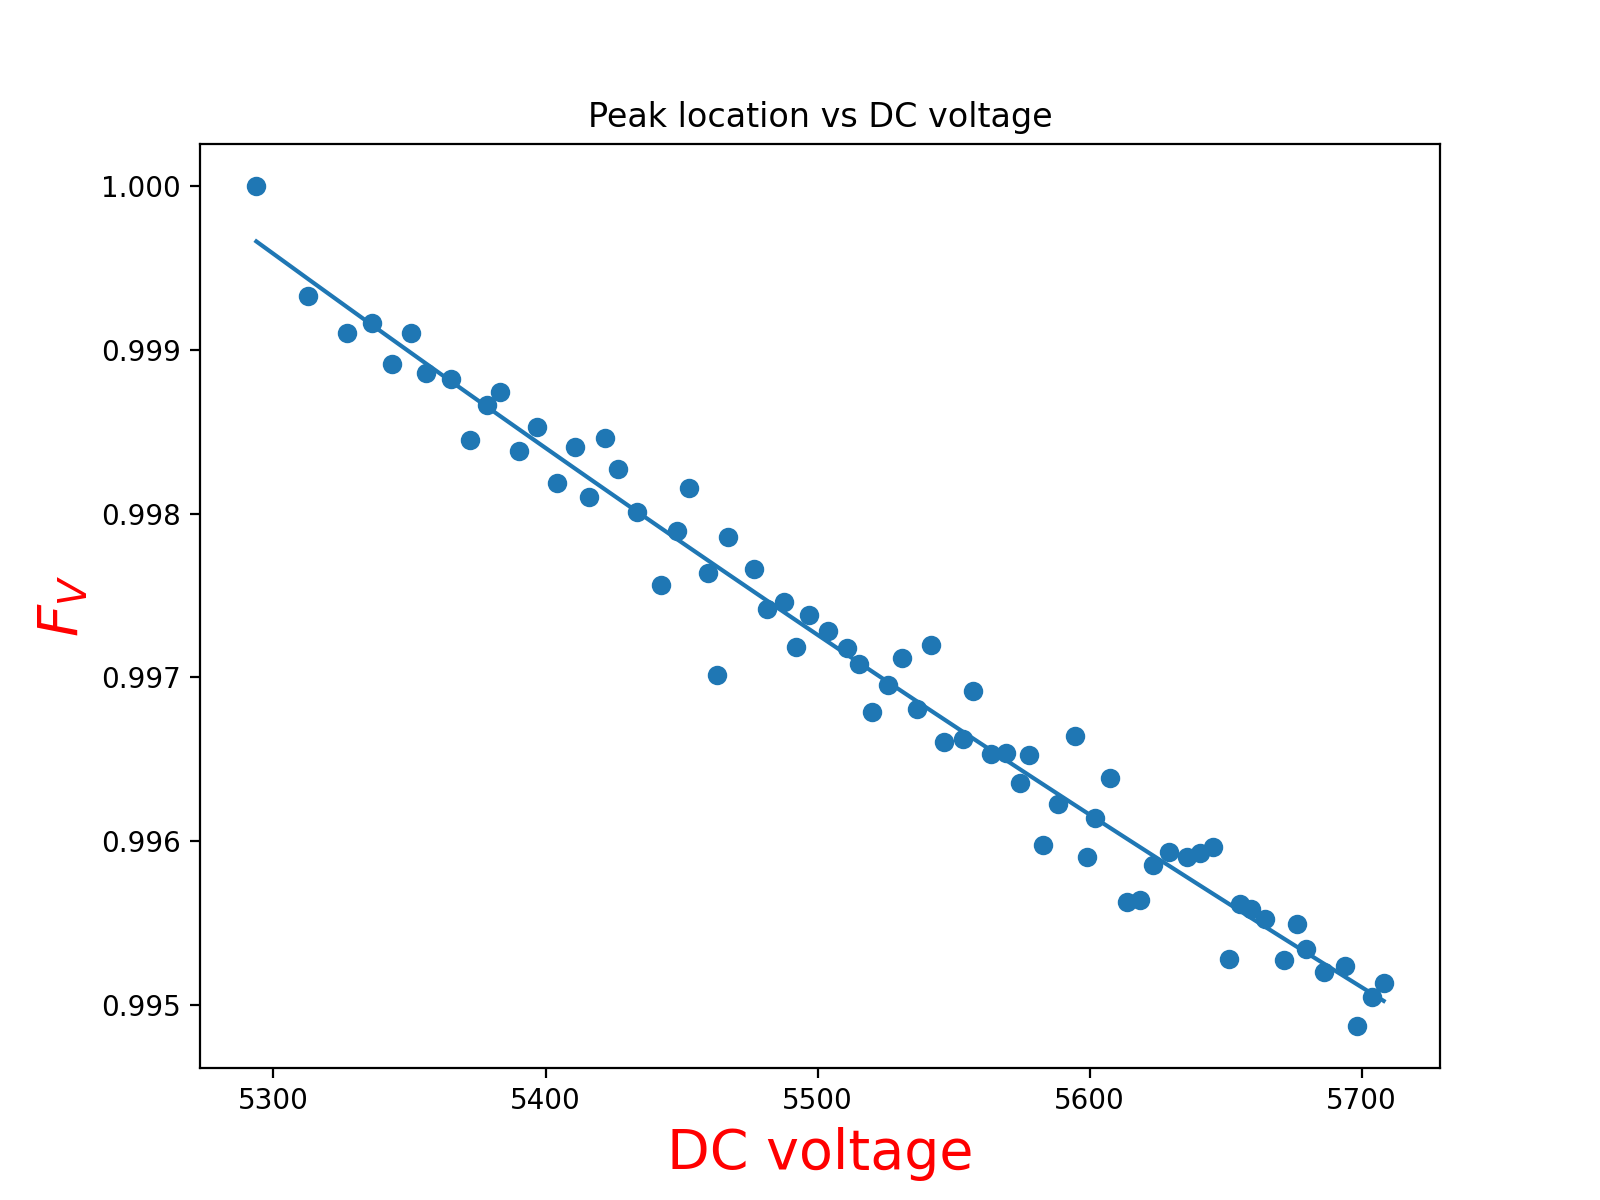

<IPython.core.display.Javascript object>


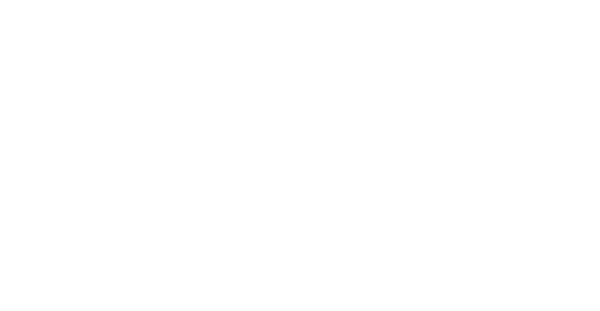

Iteration: 0 Voltage correction
Peaks in the 2D histogram [array([21.6796875]), array([23.6328125])]
Maximum pick value: [22.42594221] right-left side of the peak: [22.12567192 22.92639269]
Mass resolving power (MRP --> m/m_2-m_1): [28.00719439]


<IPython.core.display.Javascript object>


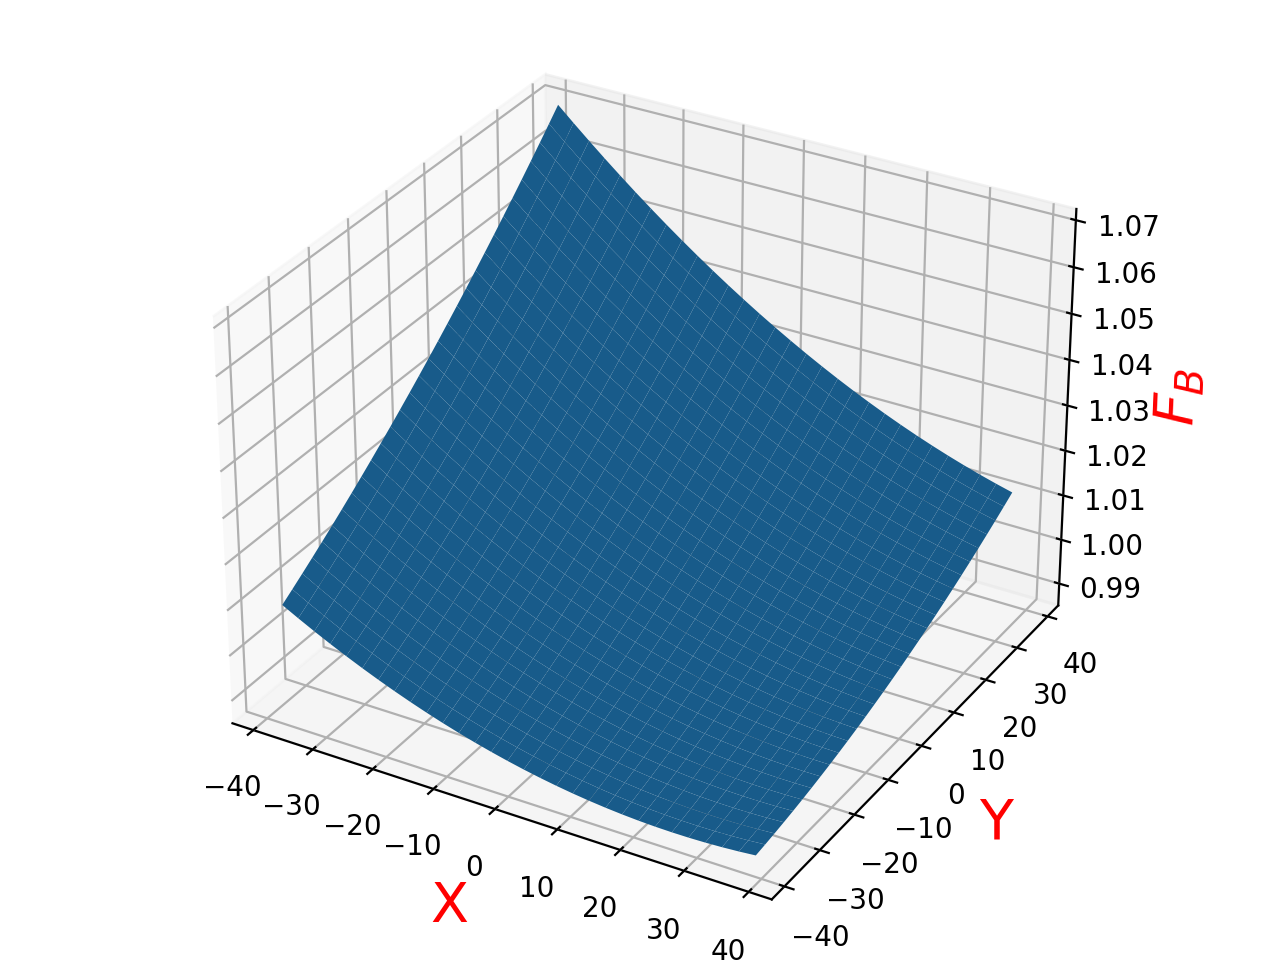

<IPython.core.display.Javascript object>


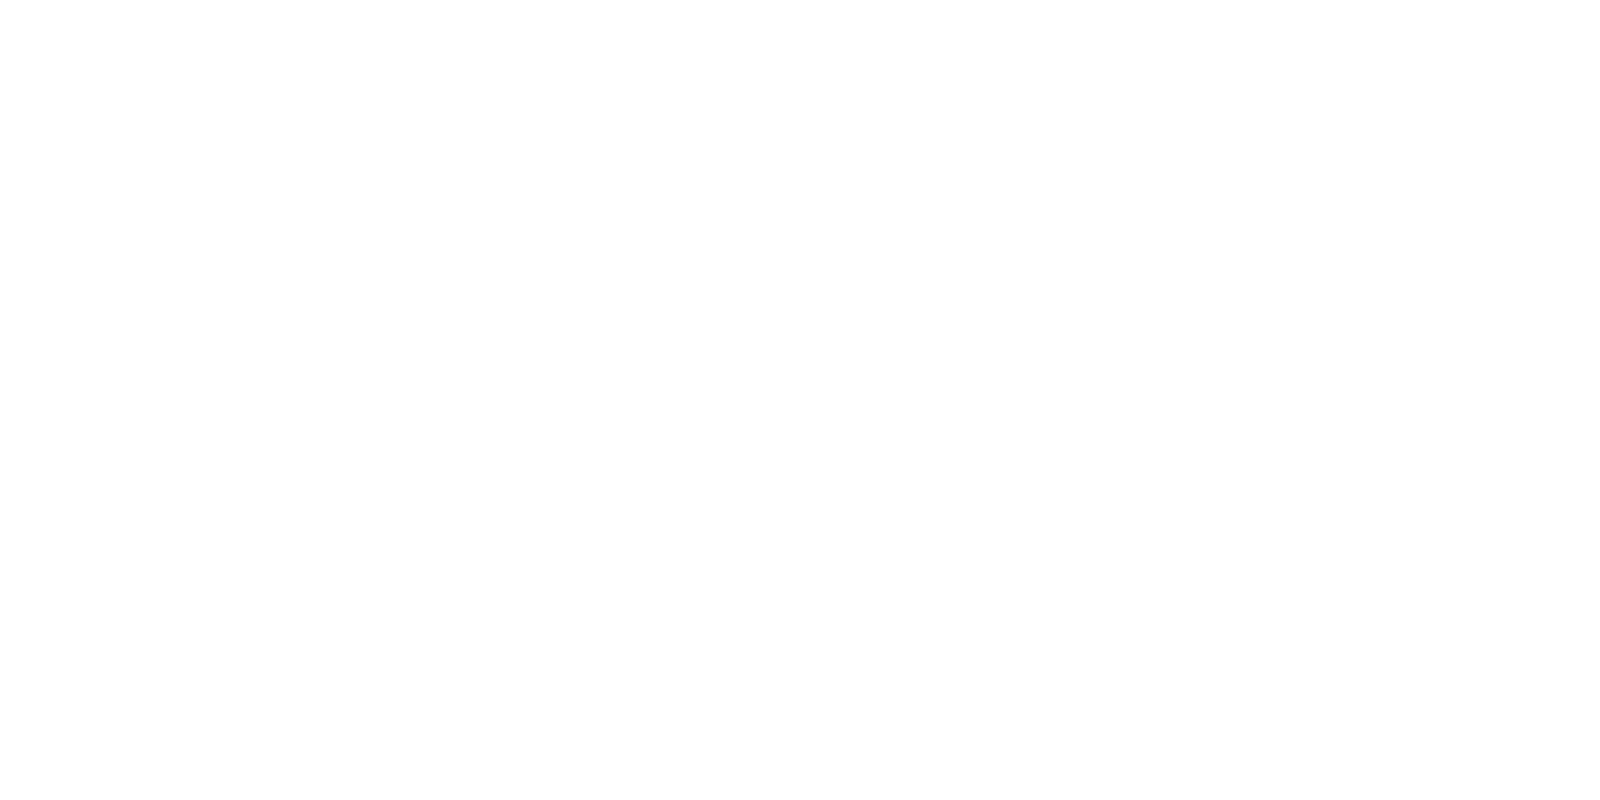

Iteration: 0 Bowl correction
Peaks in the 2D histogram [array([21.6796875]), array([23.6328125])]
Maximum pick value: [22.32417789] right-left side of the peak: [22.22409445 22.42426133]
Mass resolving power (MRP --> m/m_2-m_1): [28.00719439]


<IPython.core.display.Javascript object>


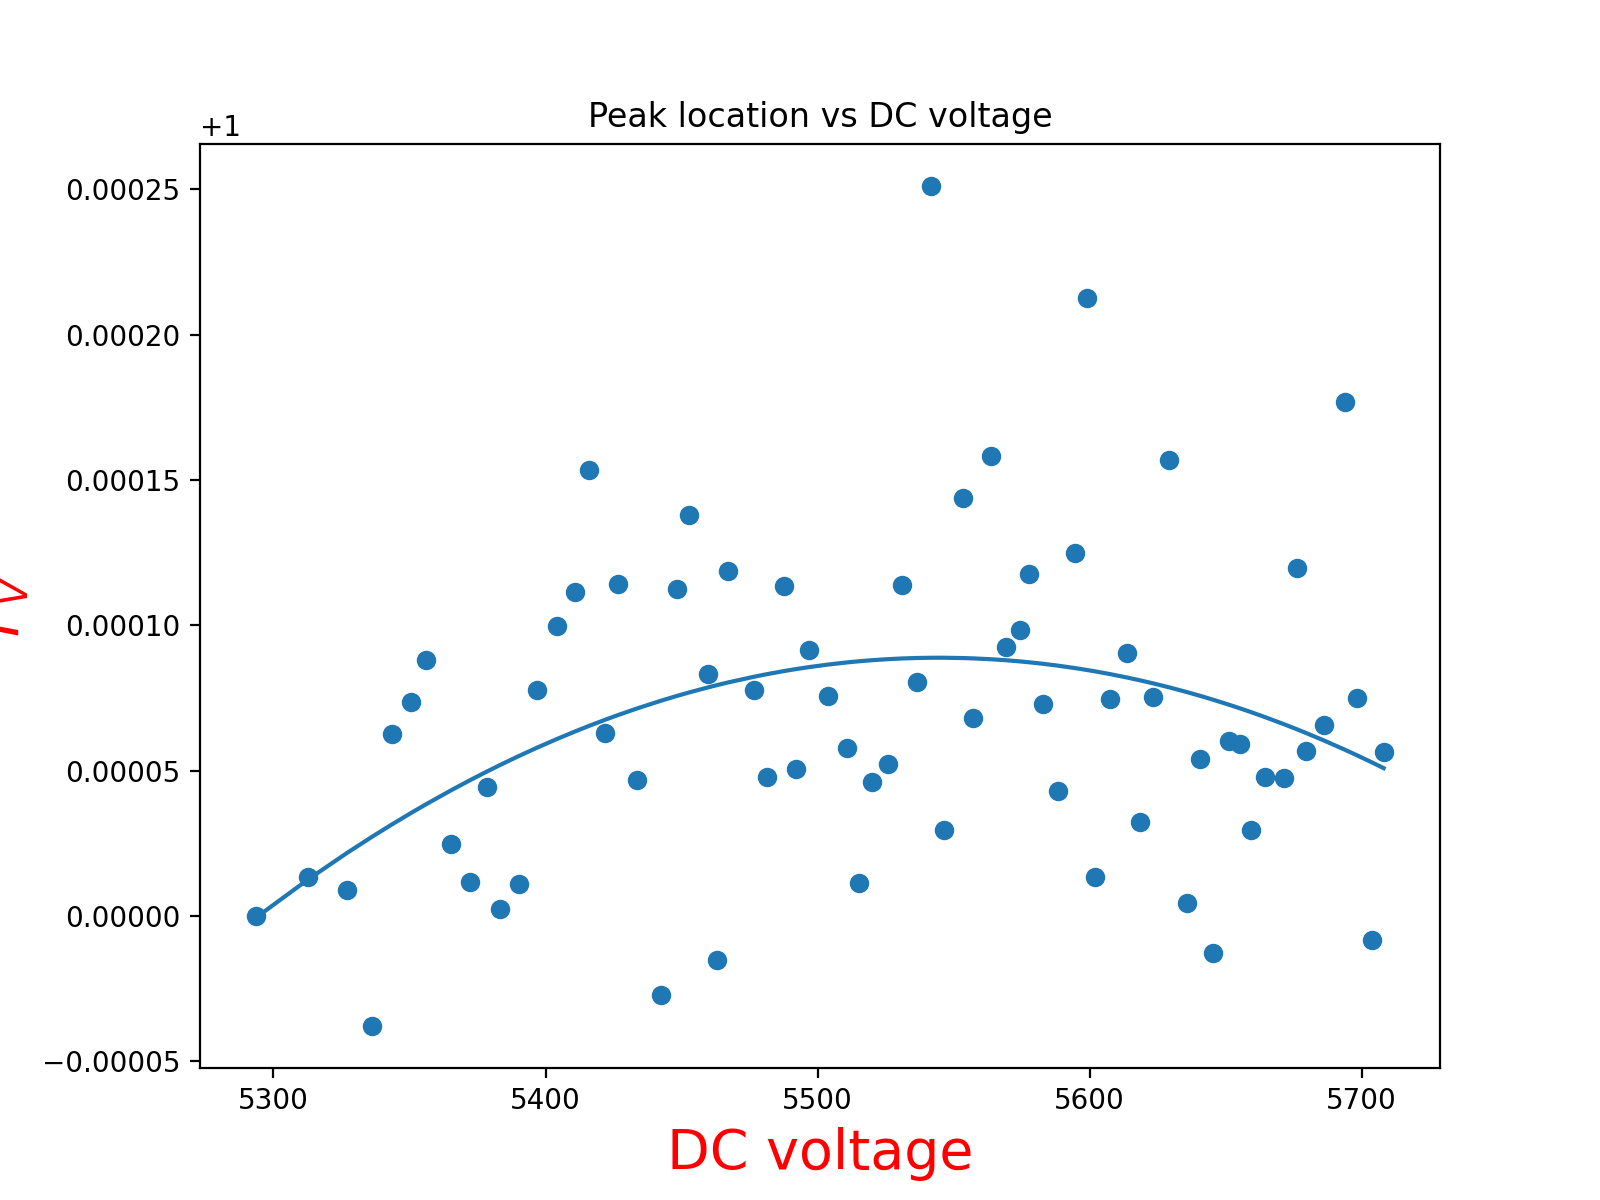

<IPython.core.display.Javascript object>


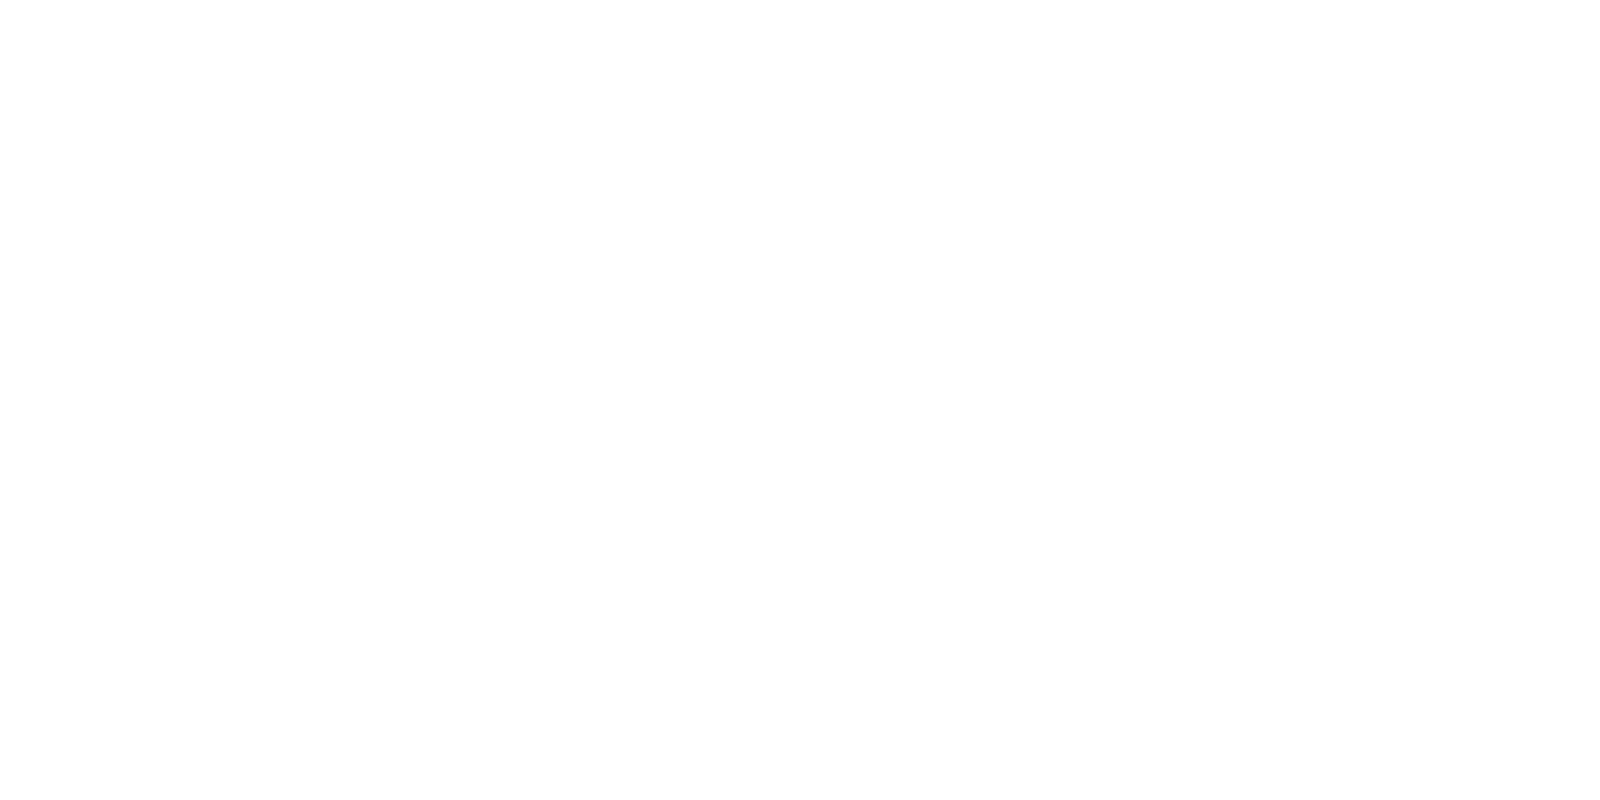

Iteration: 1 Voltage correction
Peaks in the 2D histogram [array([21.6796875]), array([23.4375])]
Maximum pick value: [22.32559996] right-left side of the peak: [22.22551014 22.42568978]
Mass resolving power (MRP --> m/m_2-m_1): [111.52782353]


<IPython.core.display.Javascript object>


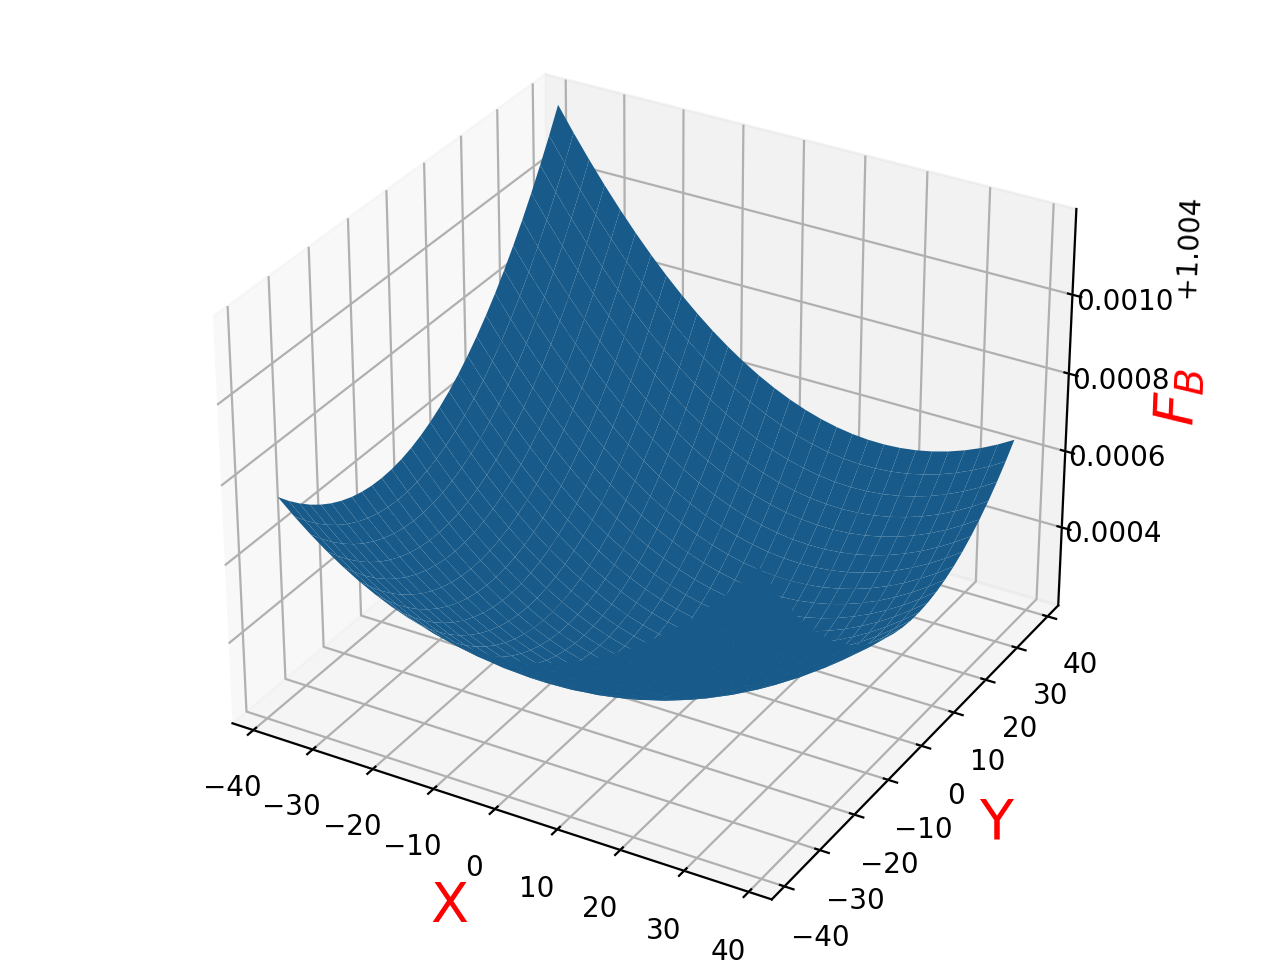

<IPython.core.display.Javascript object>


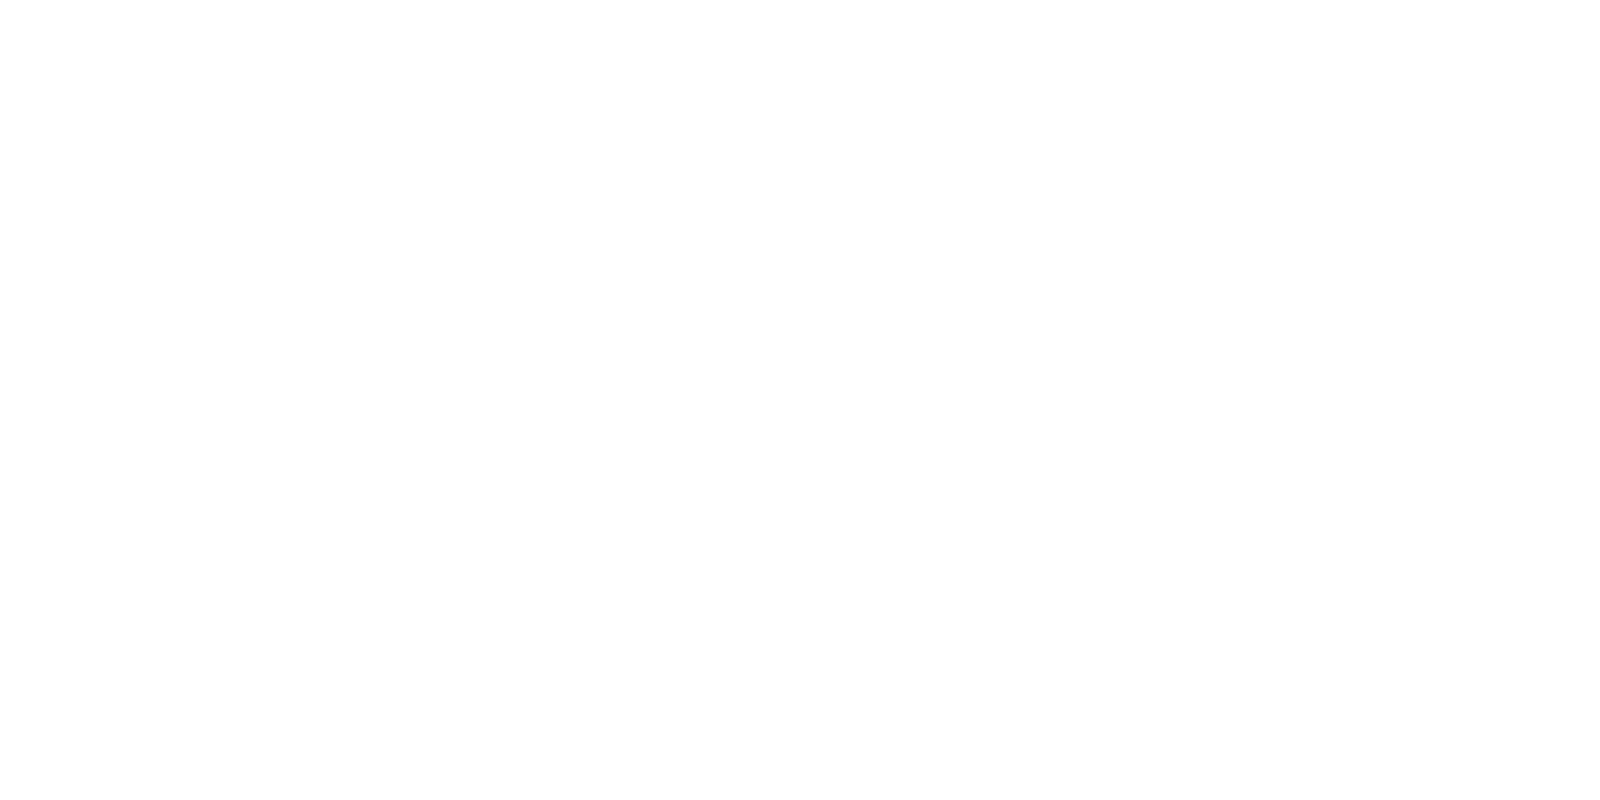

Iteration: 1 Bowl correction
Peaks in the 2D histogram [array([21.6796875]), array([23.4375])]
Maximum pick value: [22.21988112] right-left side of the peak: [22.11981654 22.3199457 ]
Mass resolving power (MRP --> m/m_2-m_1): [111.52782353]


<IPython.core.display.Javascript object>


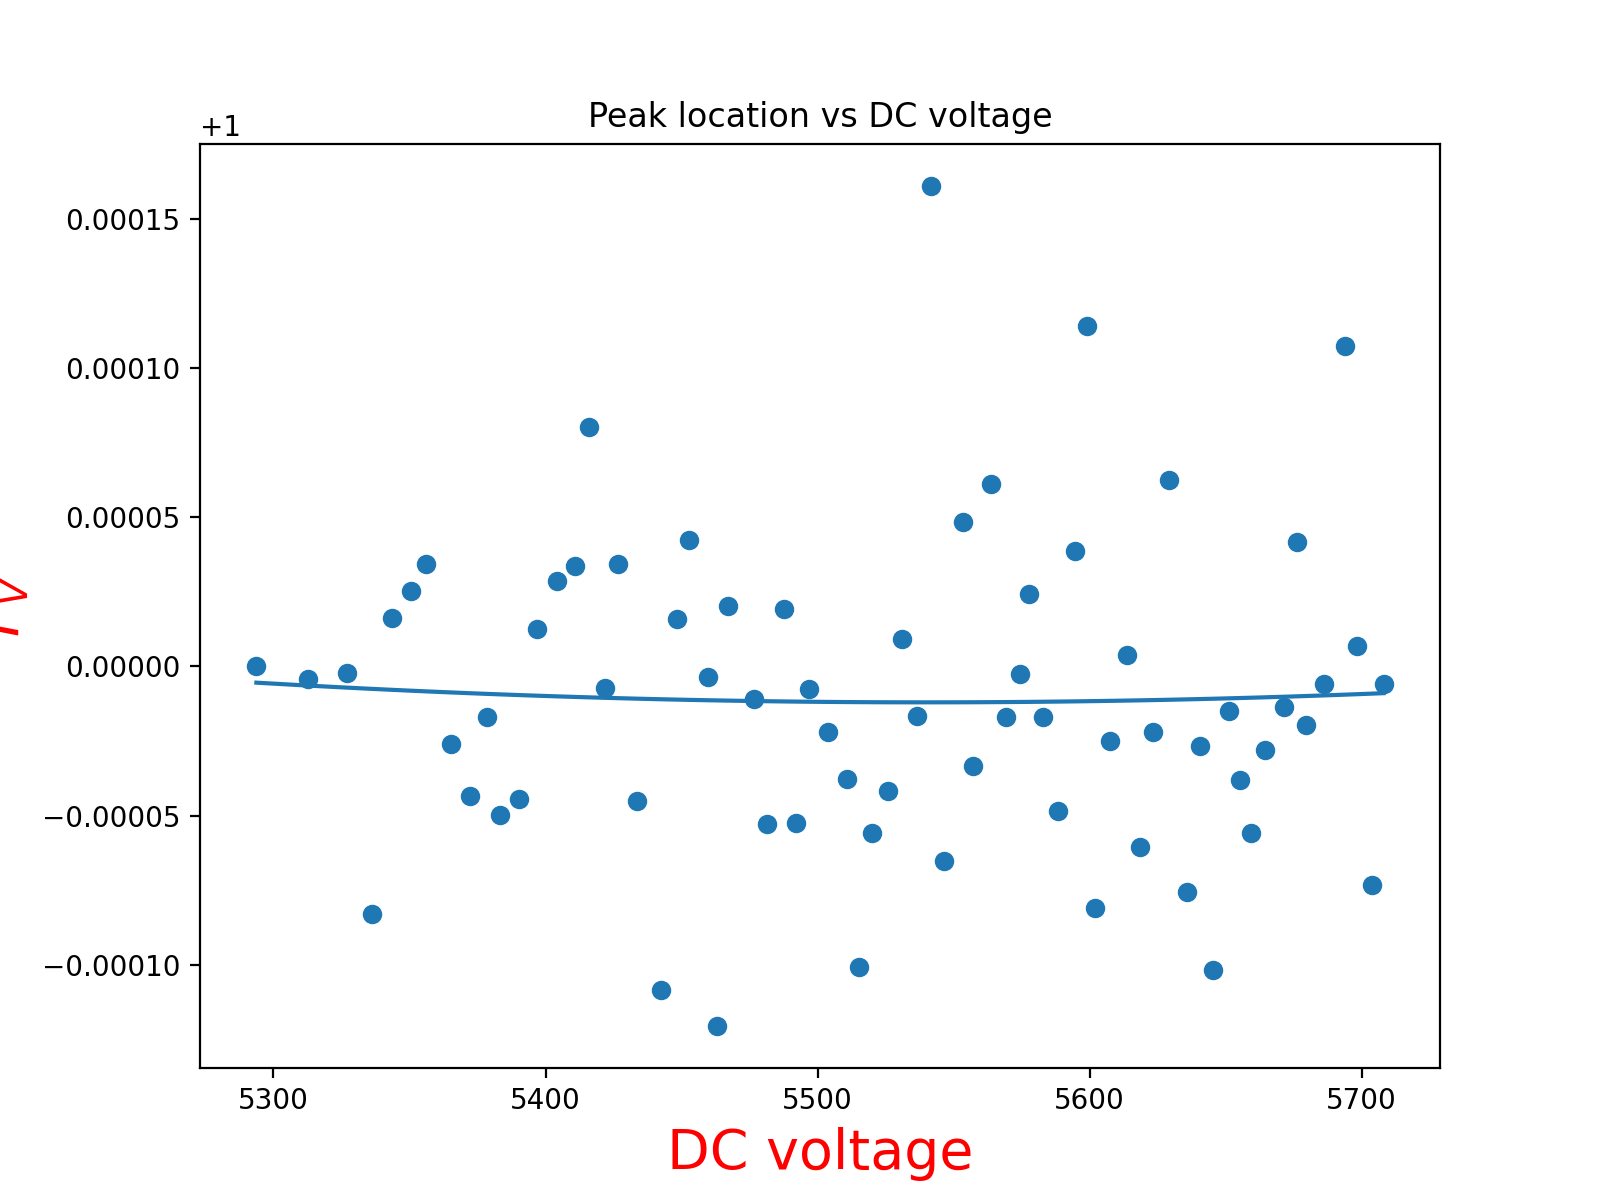

<IPython.core.display.Javascript object>


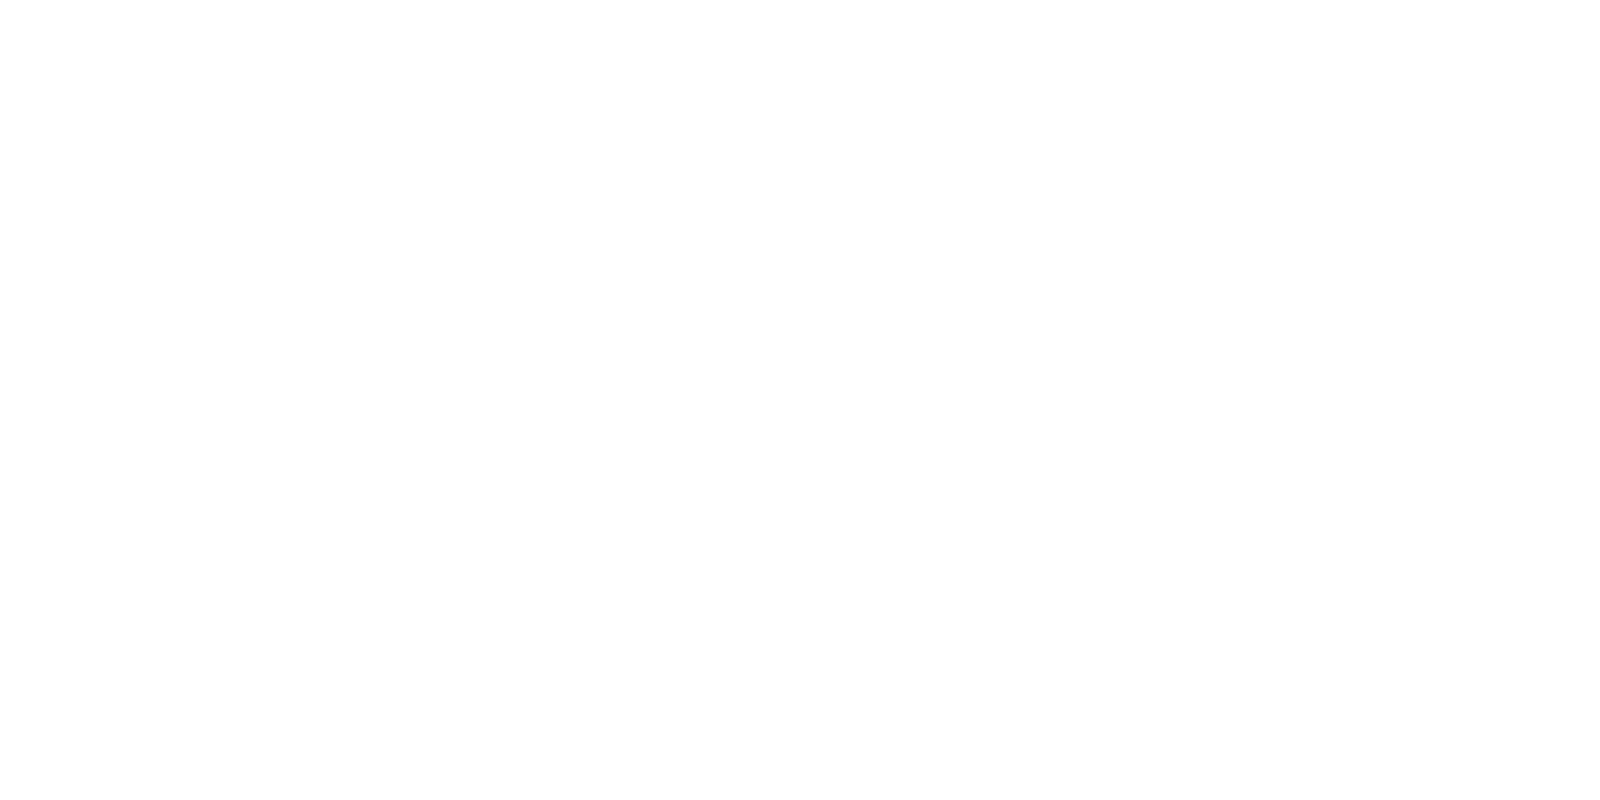

Iteration: 2 Voltage correction
Peaks in the 2D histogram [array([21.6796875]), array([23.2421875])]
Maximum pick value: [22.22011016] right-left side of the peak: [22.12004455 22.32017577]
Mass resolving power (MRP --> m/m_2-m_1): [111.02770581]


<IPython.core.display.Javascript object>


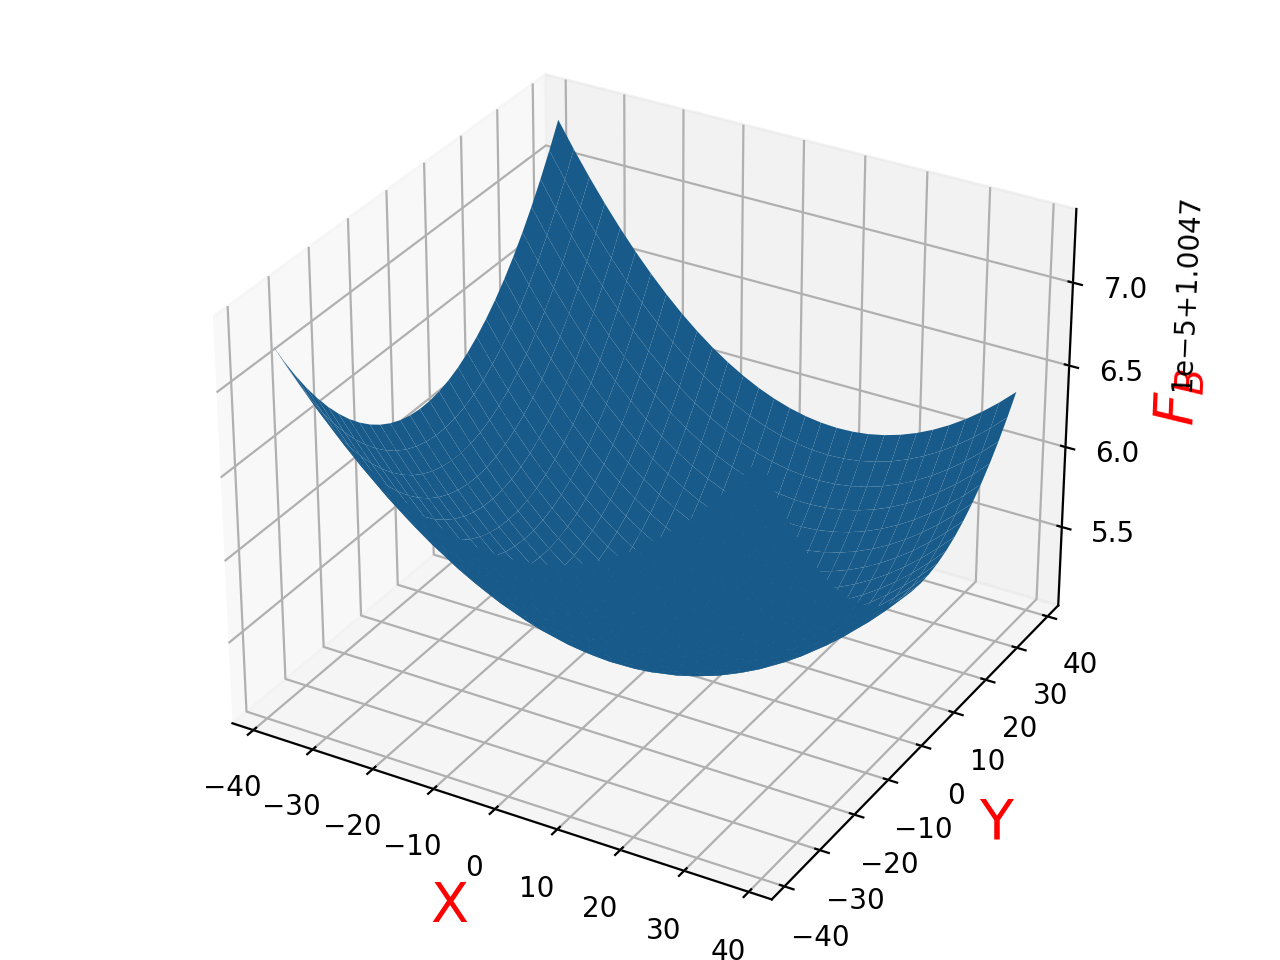

<IPython.core.display.Javascript object>


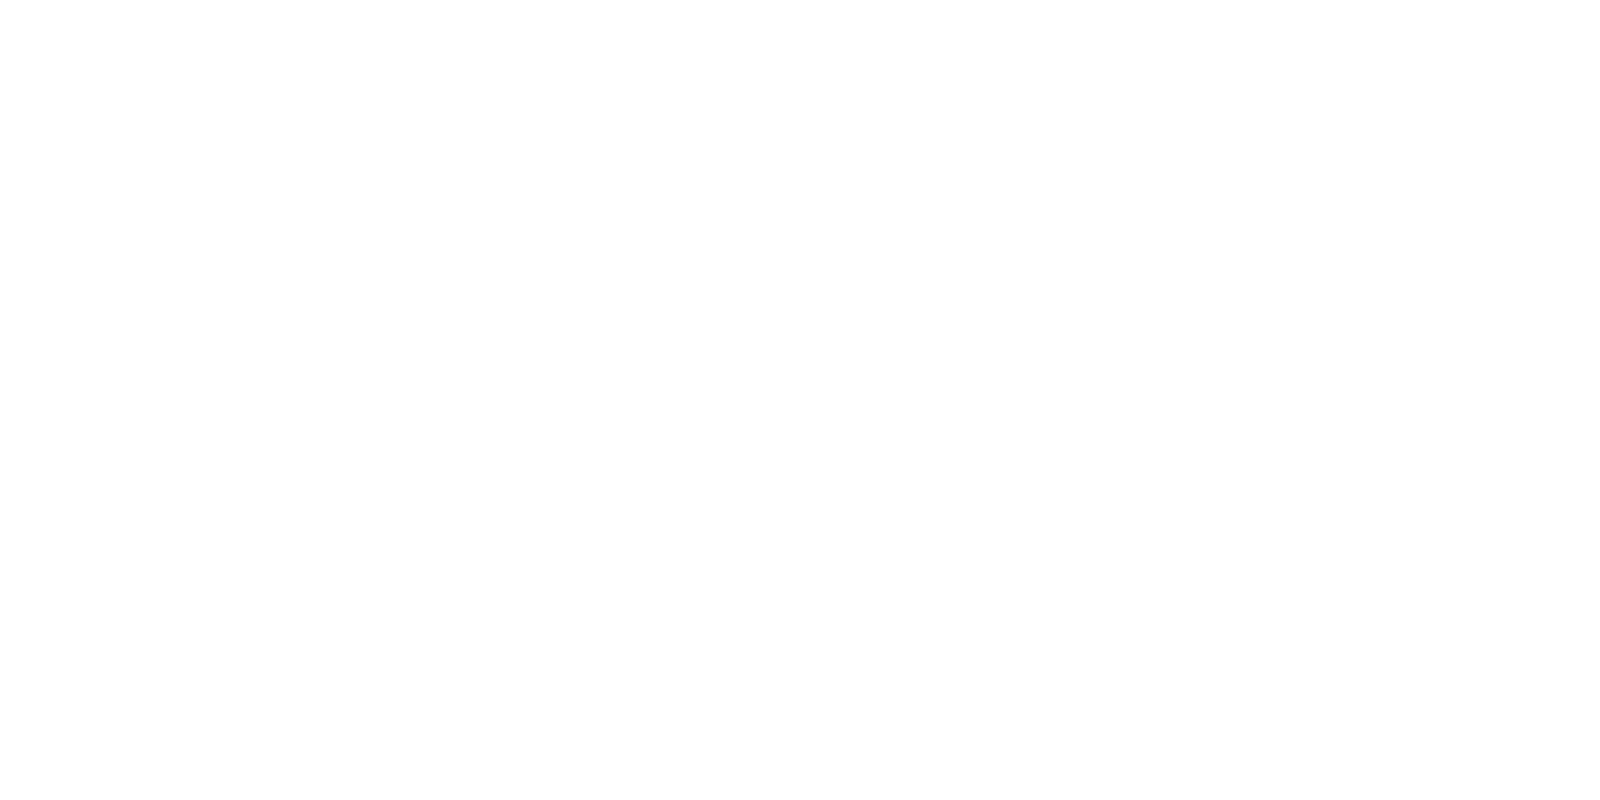

Iteration: 2 Bowl correction
Peaks in the 2D histogram [array([21.6796875]), array([23.2421875])]
Maximum pick value: [22.12278414] right-left side of the peak: [22.02270601 22.22286226]
Mass resolving power (MRP --> m/m_2-m_1): [111.02770581]


<IPython.core.display.Javascript object>


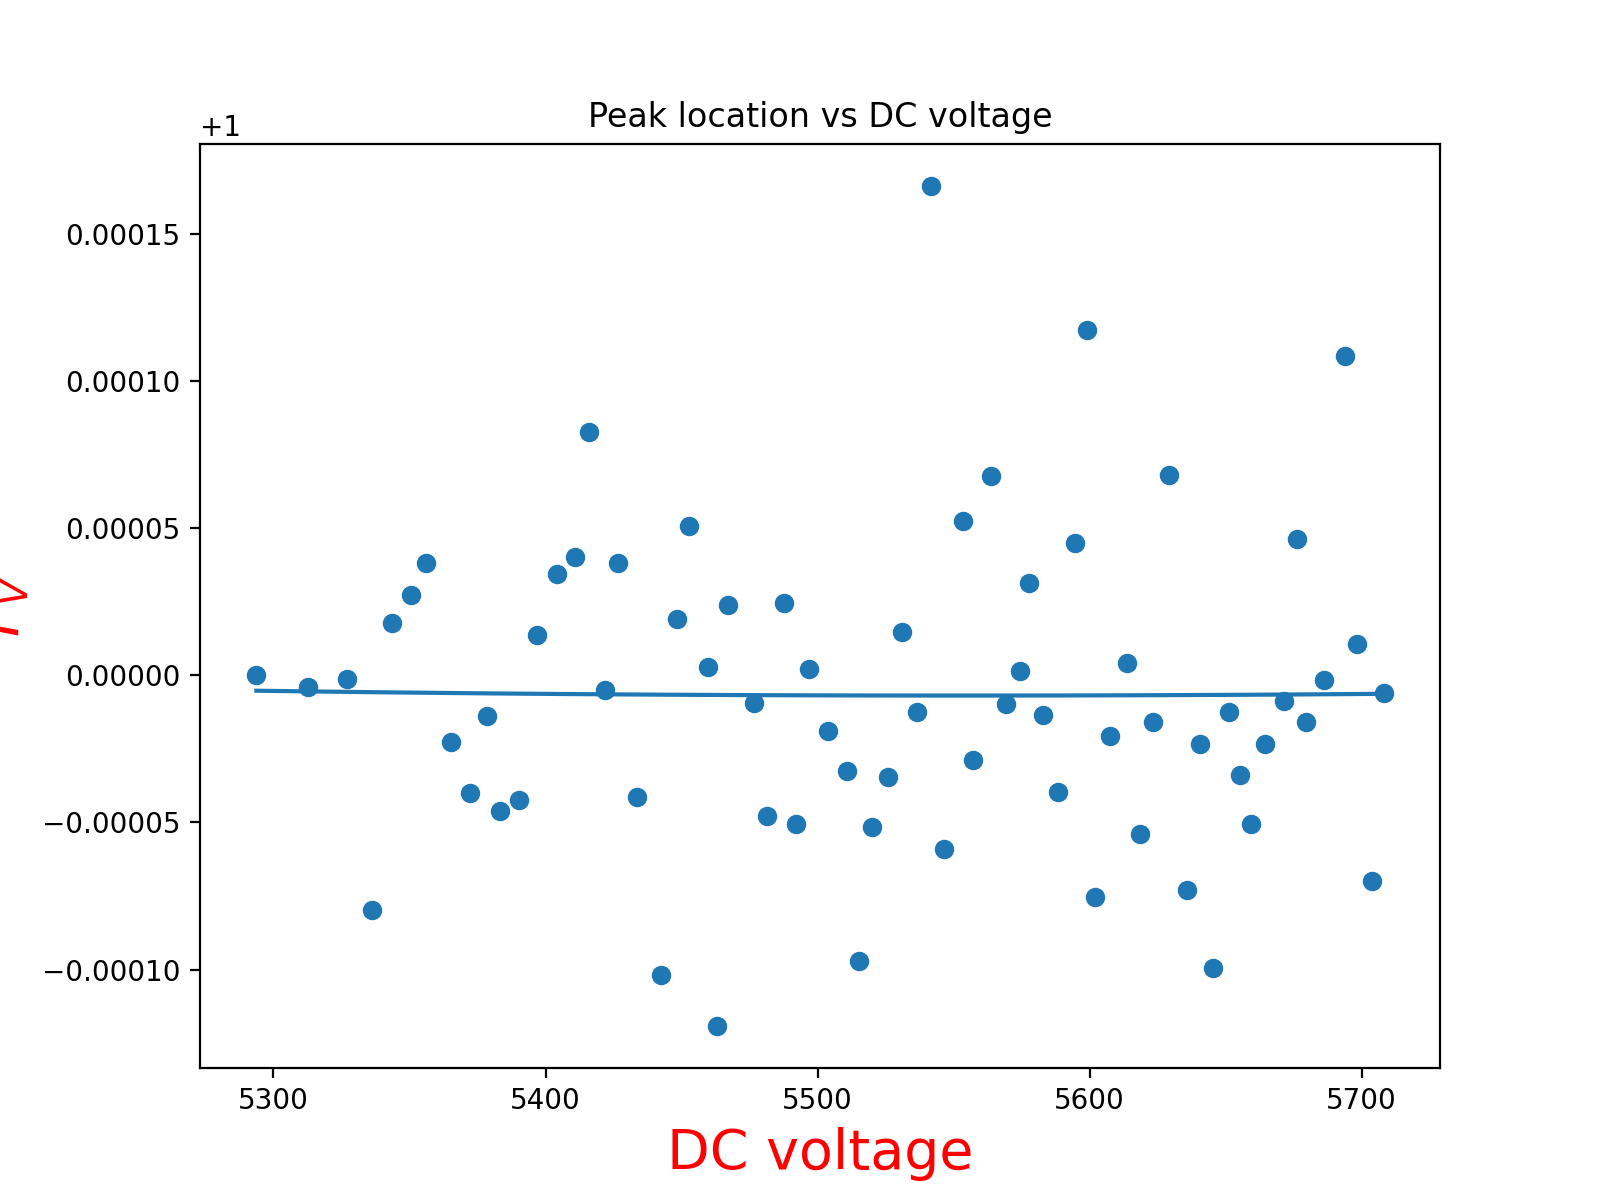

<IPython.core.display.Javascript object>


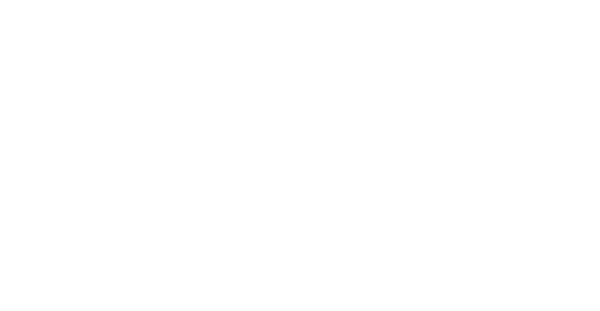

Iteration: 3 Voltage correction
Peaks in the 2D histogram [array([21.484375]), array([23.2421875])]
Maximum pick value: [22.12292999] right-left side of the peak: [22.0228512  22.22300877]
Mass resolving power (MRP --> m/m_2-m_1): [110.52757118]


<IPython.core.display.Javascript object>


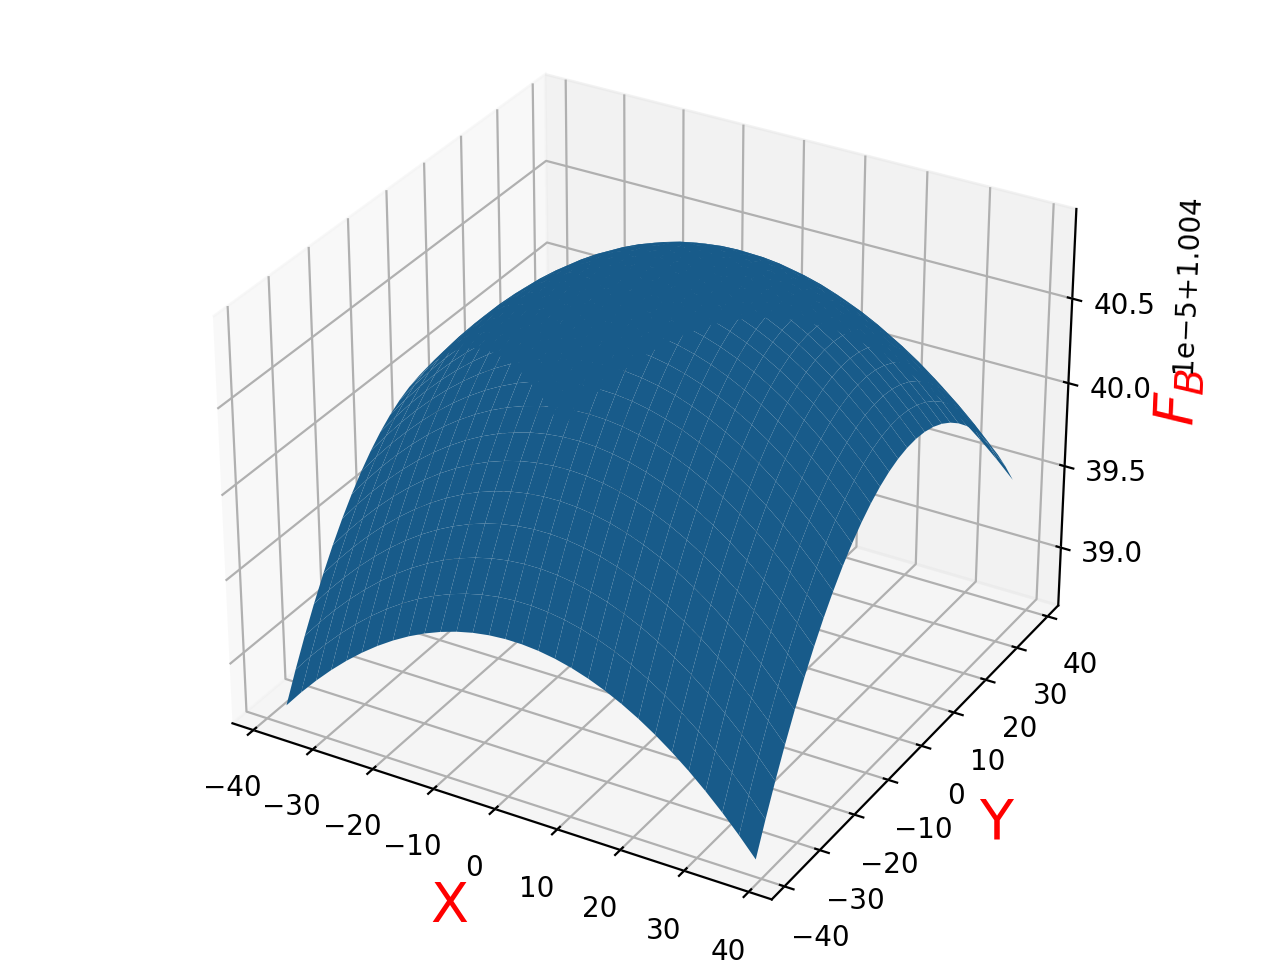

<IPython.core.display.Javascript object>


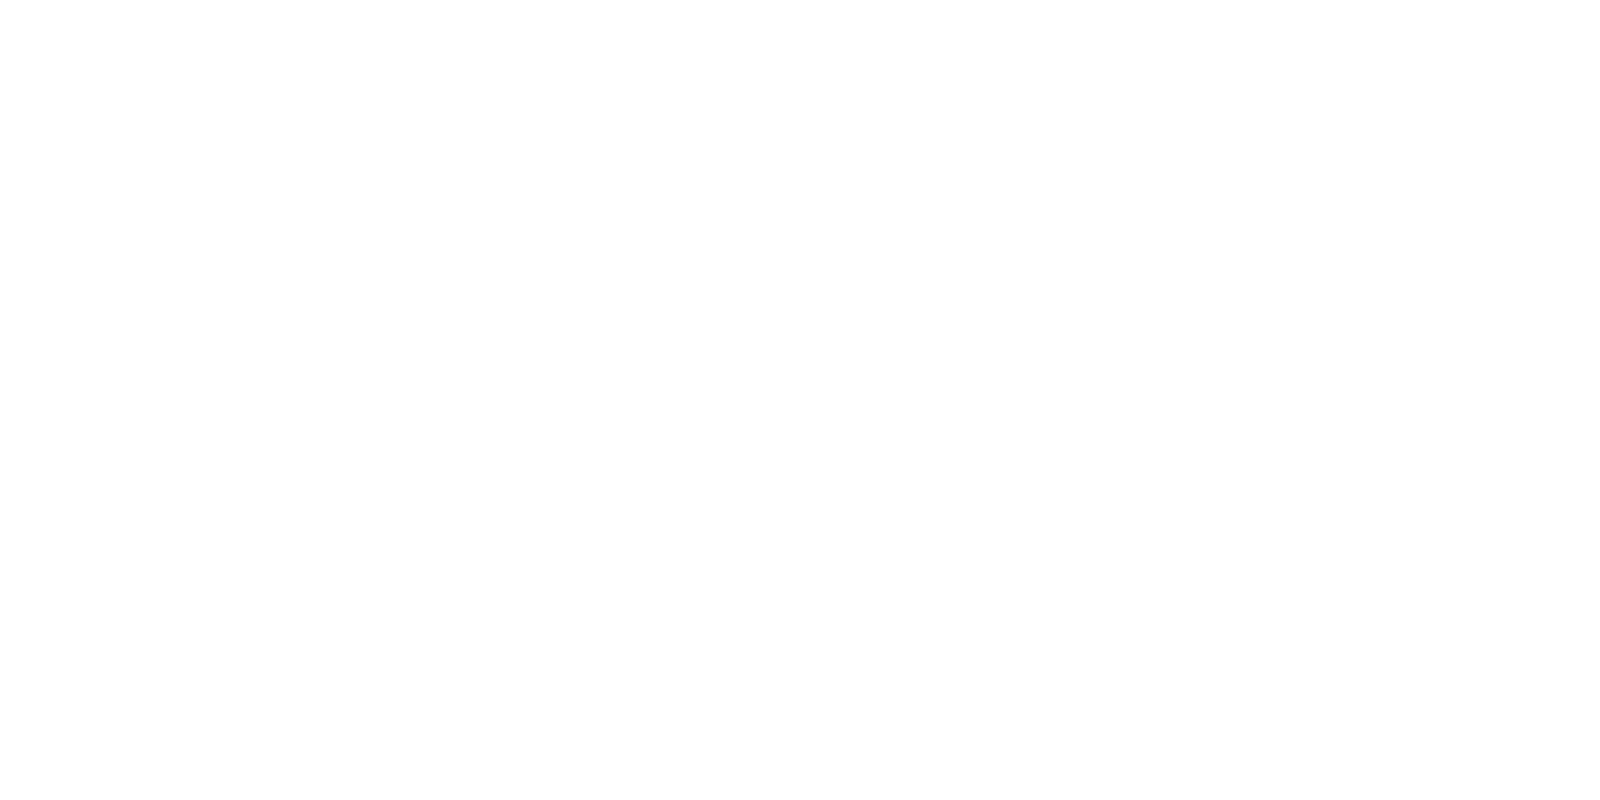

Iteration: 3 Bowl correction
Peaks in the 2D histogram [array([21.484375]), array([23.2421875])]
Maximum pick value: [22.02626613] right-left side of the peak: [21.92617171 22.12636054]
Mass resolving power (MRP --> m/m_2-m_1): [110.52757118]


In [8]:
while True:
    fitPeak = tools.history_ex(mc_temp, dld_highVoltage, mean_t, plot=False)
    corrFac_voltage = tools.voltage_corr(dld_highVoltage, mc_temp, fitPeak, ionsPerFitSegment, plot=True, fig_name='%s_'%break_i + figname)
    mc_temp2 = mc_temp / corrFac_voltage
    max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_temp2[mc_temp2 < 100], 0.1, plot=False)
    mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
    if mrp_final < mrp and break_i != 0:
        mrp_final = mrp
        mc_f = mc_temp2
    print('Iteration:', iteration, 'Voltage correction')
    print('Peaks in the 2D histogram', fitPeak)
    print('Maximum pick value:',max_hist , 'right-left side of the peak:', left_right_peaks)
    print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
    corrFac_bowl = tools.bowl_corr(dld_x, dld_y, mc_temp2, mcIdeal=max_hist, mc_min=max_paek_edges[0], mc_max=max_paek_edges[1], plot=True, fig_name='%s_'%break_i + figname)
    mc_temp3 = mc_temp2 / corrFac_bowl
    max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_temp3[mc_temp3 < 100], 0.1, plot=False)
    mc_temp = mc_temp3
    
    print('Iteration:', iteration, 'Bowl correction')
    print('Peaks in the 2D histogram', fitPeak)
    print('Maximum pick value:',max_hist , 'right-left side of the peak:', left_right_peaks)
    print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
    if mrp_final < mrp and break_i != 0:
        mrp_final = mrp
        mc_f = mc_temp
    else:
        if break_i == 3:
            break
        break_i += 1

    iteration += 1


$\text{Peak the peaks that you want to use for linear correcction by slecting the red cross on top of the peak}$

<IPython.core.display.Javascript object>


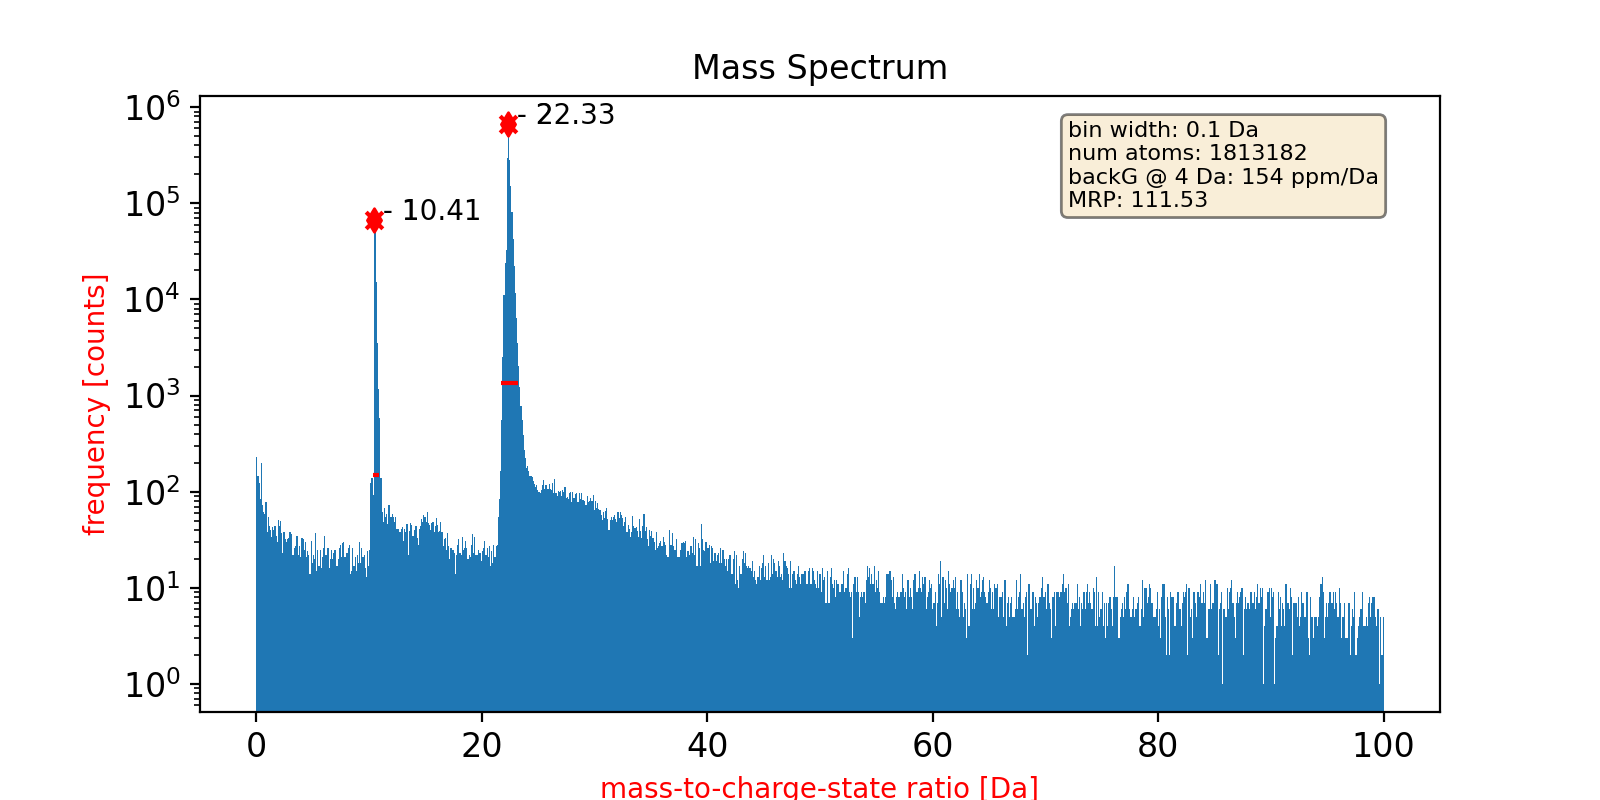

In [9]:
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_f[mc_f < 100], 0.1, plot=True, prominence=100, fig_name='cor_'+figname, text_loc='right')

In [10]:
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]))

Peaks  0 is: 10.41
Peaks  1 is: 22.33


$\text{Here we should choose the m/c for the selected above peak}$

In [11]:
isotopeTableFile = '../../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList,elementIsotopeList,elementMassList,abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0],element[1],element[3]),element[2],)
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown)
display(chargeDropdown)
display(buttonAdd)
display(buttonDelete)
display(buttonReset)
listMaterial = buttonAdd.on_click(wd.onClickAdd)
buttonDelete.on_click(wd.onClickDelete)
buttonReset.on_click(wd.onClickReset)

Dropdown(description='Elements', options=(('H (1) (99.98)', 1.01), ('H (2) (0.01)', 2.01), ('He (3) (0.00)', 3…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

In [14]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(peaks_sides[variables.peaks_idx[i],0])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(listMaterial)
print('highest peak in the mc histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', variables.listMaterial)

highest peak in the mc histogram: [10.41491117 22.32559996]
highest peak in the ideal mc histogram: [13.49, 26.98]


$\text{Above you should see the selected peak values and the ideal m/c for them seperatly. By runing the below cell linear correction aplies on the m/c and the final result is plotted}$

In [ ]:
# For quadratic you need at least 3 points
mc_final = tools.linear_correction(mc_f, peaks_chos, np.array(variables.listMaterial), kind='linear')

In [ ]:
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, plot=True)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max  = tools.massSpecPlot(mc_f[mc_f < 100], 0.1, plot=True, prominence=800, fig_name=None, text_loc='right')
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max  = tools.massSpecPlot(mc_final[mc_final < 100], 0.1, plot=True, prominence=800, fig_name='linear_cor_'+figname, text_loc='right')
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)

<IPython.core.display.Javascript object>


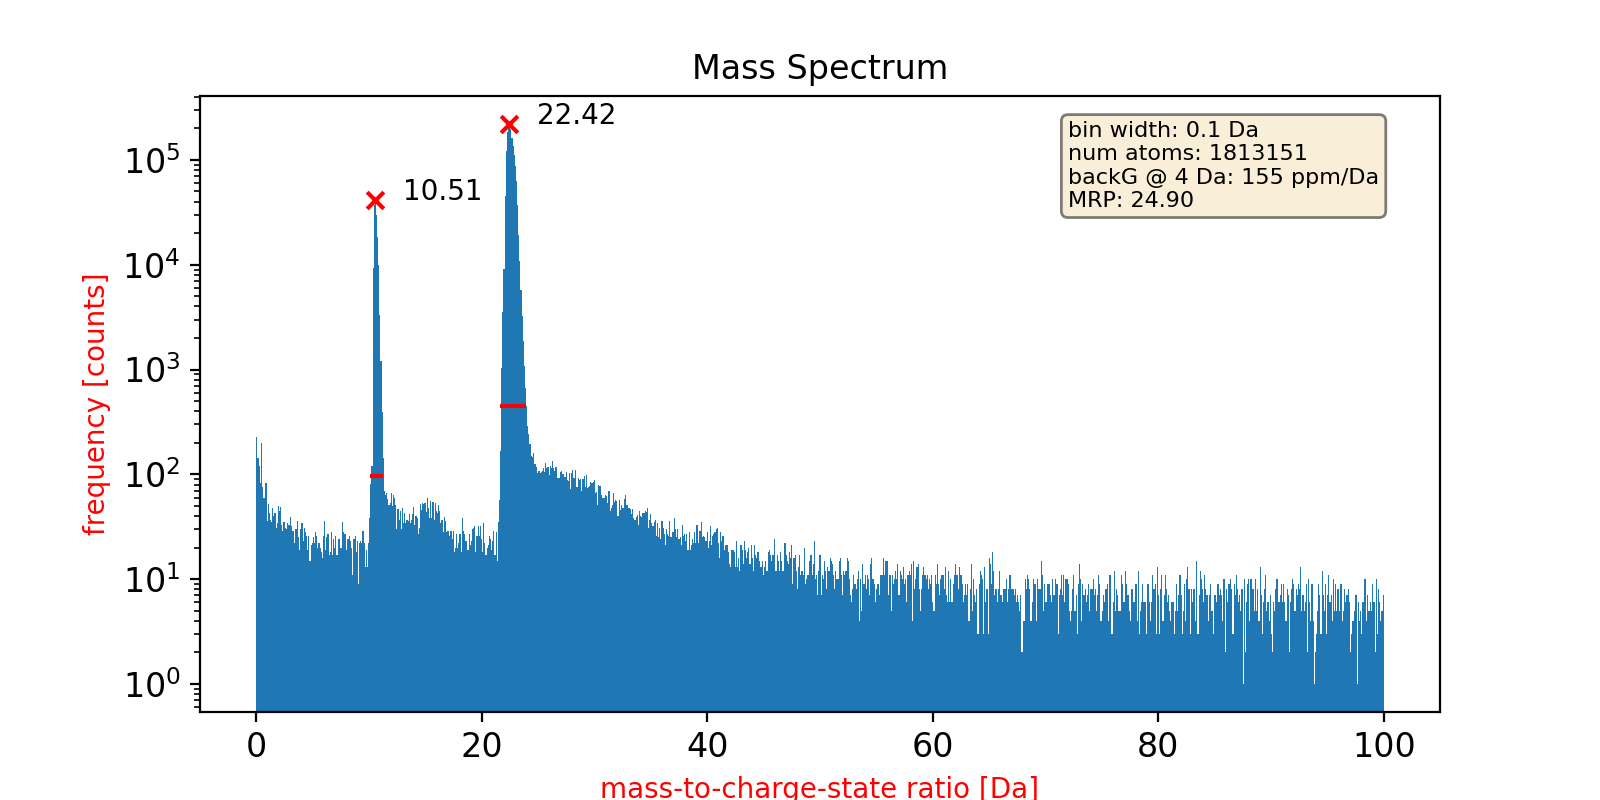

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [24.89528023]


<IPython.core.display.Javascript object>


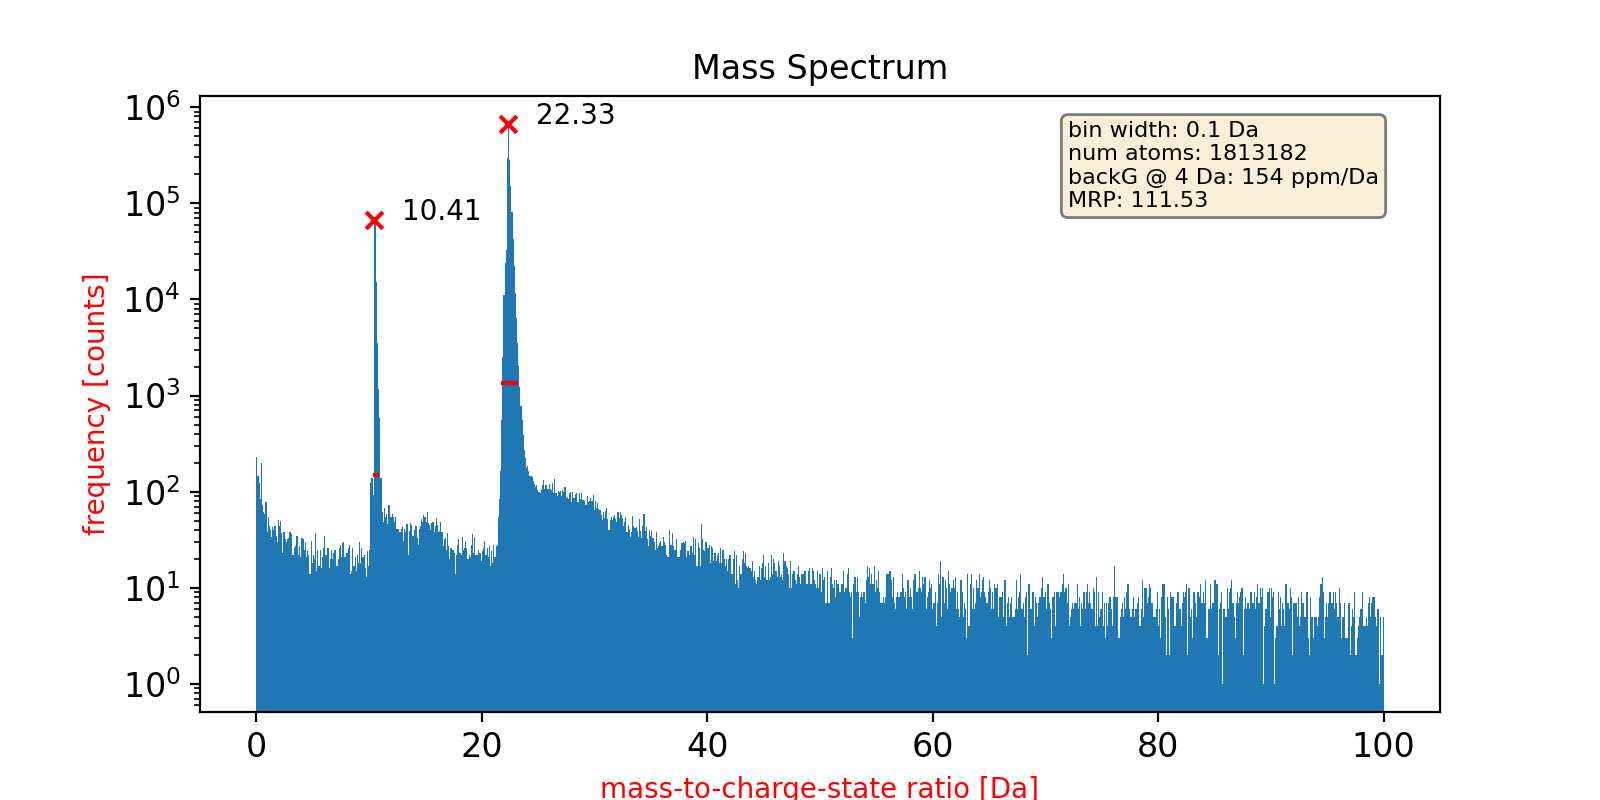

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [111.52782353]


<IPython.core.display.Javascript object>


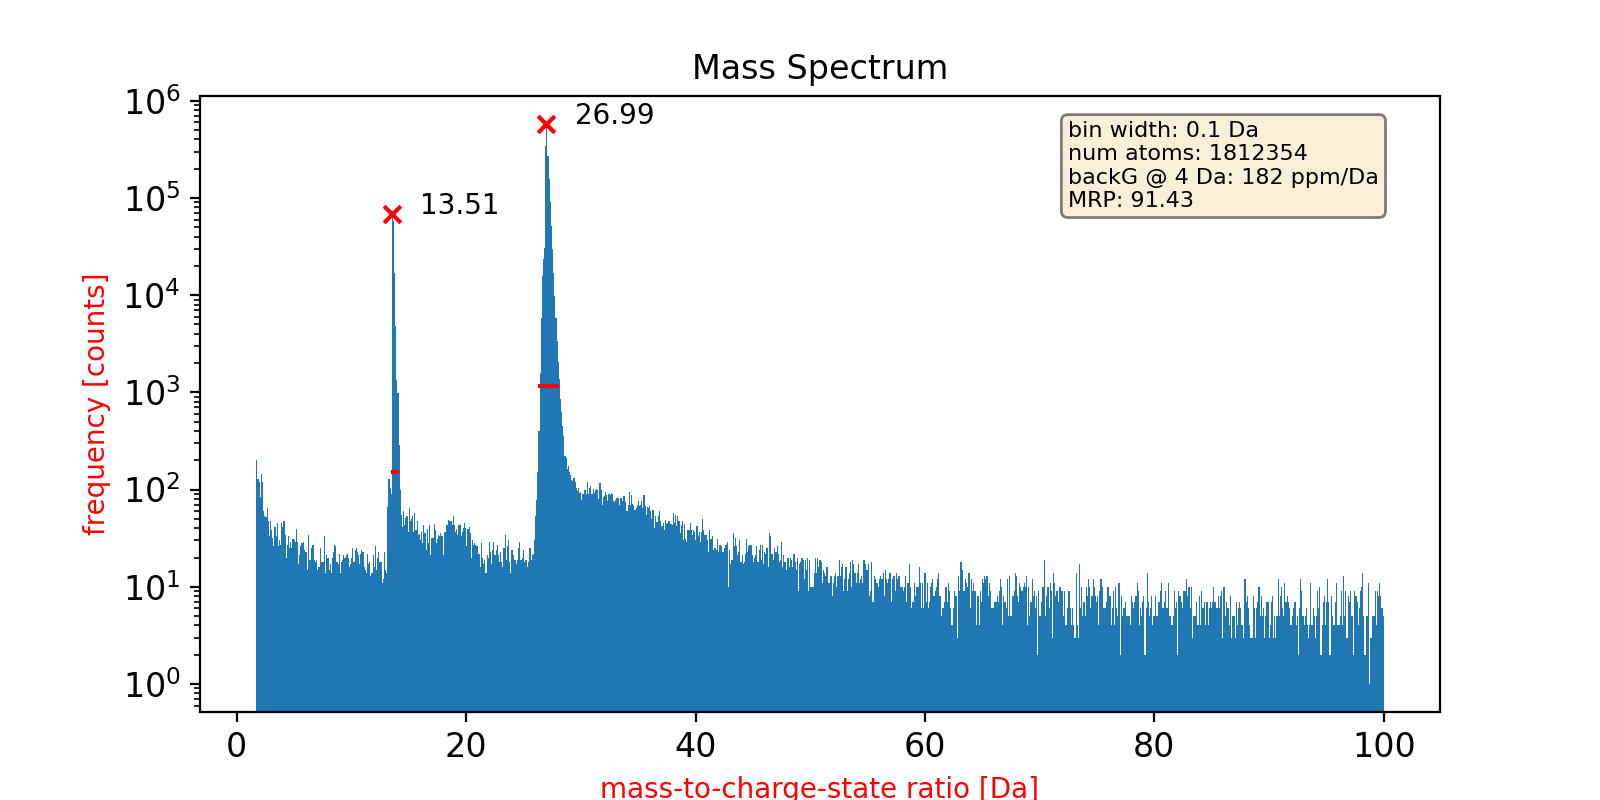

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [91.427746]


In [17]:
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, plot=True)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max  = tools.massSpecPlot(mc_f[mc_f < 100], 0.1, plot=True, prominence=800, fig_name=None, text_loc='right')
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max  = tools.massSpecPlot(mc_final[mc_final < 100], 0.1, plot=True, prominence=800, fig_name='linear_cor_'+figname, text_loc='right')
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)